In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hyperparameter_tuning import *

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  

from sklearn.preprocessing import StandardScaler
from hyperparameter_tuning import *
import os
import lightgbm as lgb

from sklearn.linear_model import LinearRegression, LogisticRegression

/Users/jordan/anaconda3/envs/challengeQRT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_nan_percentage(dataframe):
    # Count the number of NaN values in each column
    nan_counts = dataframe.isna().sum()

    # Calculate the percentage of NaN values in each column
    nan_percentage = (nan_counts / len(dataframe)) * 100

    return nan_percentage.sort_values(ascending=False)

In [3]:
def plot_N_best_features(model, feature_names, N):
    # Extract feature importances
    feature_importance_values = model.feature_importances_

    # Create a DataFrame using feature names and their importances
    features_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Sort features based on importance
    features_df = features_df.sort_values(by='importance', ascending=False)

    # Select the top N important features
    top_features_df = features_df.head(N)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(top_features_df['feature'], top_features_df['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {N} Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()
    return top_features_df
# Assuming feature_names is a list of your feature names


In [4]:
data_team_home=pd.read_csv('X_data_team_home_preproc.csv',index_col='ID')
data_team_away=pd.read_csv('X_data_team_away_preproc.csv',index_col='ID')
data_player_home=pd.read_csv('X_data_home_player_preproc.csv',index_col='ID')
data_player_away=pd.read_csv('X_data_away_player_preproc.csv',index_col='ID')

In [5]:
data_team_home_test=pd.read_csv('X_data_team_home_test_preproc.csv',index_col='ID')
data_player_home_test=pd.read_csv('X_data_home_player_test_preproc.csv',index_col='ID')

In [6]:
Y_data_train=pd.read_csv('Y_train_1rknArQ.csv',index_col='ID')  
Y_data_train_score=pd.read_csv(r'data/Y_train_supp.csv',index_col='ID') 

In [7]:
Y_data_train_1=Y_data_train['HOME_WINS']-Y_data_train['AWAY_WINS']
Y_data_train_1=pd.DataFrame(Y_data_train_1,columns=['TARGET'])
Y_data_train_1

,TARGET
ID,
0,-1
1,0
2,-1
3,1
4,0
...,...
12298,-1
12299,-1
12300,-1


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00, 0.000e+00, 1.000e+01, 0.000e+00, 3.500e+01,
        0.000e+00, 1.690e+02, 0.000e+00, 4.270e+02, 0.000e+00, 9.920e+02,
        0.000e+00, 0.000e+00, 2.120e+03, 0.000e+00, 3.186e+03, 0.000e+00,
        2.702e+03, 0.000e+00, 1.495e+03, 0.000e+00, 7.320e+02, 0.000e+00,
        2.970e+02, 0.000e+00, 0.000e+00, 9.400e+01, 0.000e+00, 2.700e+01,
        0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([-13.  , -12.54, -12.08, -11.62, -11.16, -10.7 , -10.24,  -9.78,
         -9.32,  -8.86,  -8.4 ,  -7.94,  -7.48,  -7.02,  -6.56,  -6.1 ,
         -5.64,  -5.18,  -4.72,  -4.26,  -3.8 ,  -3.34,  -2.88,  -2.42,
         -1.96,  -1.5 ,  -1.04,  -0.58,  -0.12,   0.34,   0.8 ,   1.26,
          1.72,   2.18,   2.64,   3.1 ,   3.56,   4.02,   4.48,   4.94,
          5.4 , 

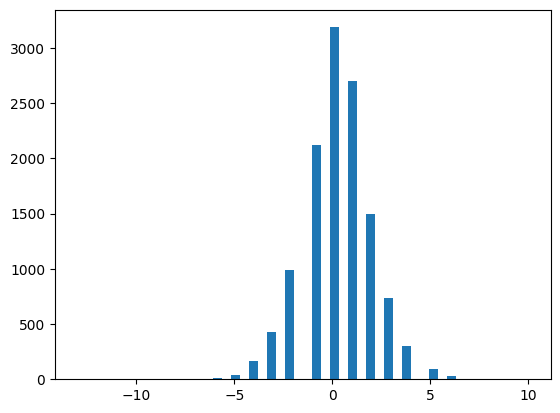

In [21]:
Y_data_train_score_01 = Y_data_train_score['GOAL_DIFF_HOME_AWAY'].apply(lambda x: 0 if x in [-1,0,1] else (1 if x <= -1 else 1))
plt.hist(Y_data_train_score,bins=50)
# plt.xticks([0, 1], ['Score -1, 0, 1', 'Absolute value score >= 2'])

In [9]:
Y_concat=pd.merge(Y_data_train_1,Y_data_train_score_01,on='ID',how='left')

In [10]:
np.abs(Y_data_train_1['TARGET']-Y_data_train_score_01).sum()/len(Y_data_train_1)

0.6587011298057385

In [11]:
X_train=data_team_home#.drop(columns=['LEAGUE','TEAM_NAME'])

In [12]:
# clf_team_home,study_team_home=run_study(X_train,Y_data_train_score['GOAL_DIFF_HOME_AWAY'].values,n_trials=100, n_jobs=2)


In [13]:
feature_names = X_train.drop(columns=['LEAGUE','TEAM_NAME']).columns # Fill in with your feature names
selected_features=plot_N_best_features(clf_team_home, feature_names,N=20)

NameError: name 'clf_team_home' is not defined

## JE M'OCCUPE DES PLAYERS RATINGS

In [ ]:
def fill_pivot(data_set):
    for index, row in data_set.iterrows():
        # Check if any cell in the row contains NaN
        if row.isnull().any():
            # Replace NaN values with the value from the first column of the same row
            data_set.loc[index] = row.fillna(row[0])
#     data_set=data_set.drop(columns='0')
    return data_set

In [ ]:
group1=data_player_home[['POSITION','PLAYER_RATING_season_std','PLAYER_RATING_5_last_match_average']].groupby(['ID', 'POSITION']).mean().reset_index().set_index('ID')


In [ ]:
group2=data_player_home_test[['POSITION','PLAYER_RATING_season_std','PLAYER_RATING_5_last_match_average']].groupby(['ID', 'POSITION']).mean().reset_index().set_index('ID')
group2

In [ ]:
data0=group1.pivot_table(index='ID', columns='POSITION')#, values='PLAYER_RATING_5_last_match_average')
data0

In [ ]:
data_test0=group2.pivot_table(index='ID', columns='POSITION')#, values='PLAYER_RATING_5_last_match_average')
data_test0

In [ ]:
data_test0['PLAYER_RATING_5_last_match_average']=fill_pivot(data_test0['PLAYER_RATING_5_last_match_average'])
data_test0['PLAYER_RATING_season_std']=fill_pivot(data_test0['PLAYER_RATING_season_std'])

In [ ]:
rows_with_more_than_2_nan = data_test0[data_test0.isnull().sum(axis=1) > 2]

# If there are any such rows, print their indices
if not rows_with_more_than_2_nan.empty:
    print("Rows with more than 2 NaN values:")
    print(rows_with_more_than_2_nan.index)
else:
    print("No rows with more than 2 NaN values.")

In [ ]:
group2.loc[13884,:]

In [ ]:
data0.columns = data0.columns.map('_'.join)
# Or with an explicit format string like:
# new_df.columns = new_df.columns.map('{0[0]}_{0[1]}'.format)
data0 = data0.reset_index()

In [ ]:
data_test0.columns = data_test0.columns.map('_'.join)
# Or with an explicit format string like:
# new_df.columns = new_df.columns.map('{0[0]}_{0[1]}'.format)
data_test0 = data_test0.reset_index()

In [ ]:
player_rating=data0.drop(columns=['PLAYER_RATING_5_last_match_average_0','PLAYER_RATING_season_std_0']).set_index('ID')


In [ ]:
player_rating_test=data_test0.drop(columns=['PLAYER_RATING_5_last_match_average_0','PLAYER_RATING_season_std_0']).set_index('ID')


## FIN PLAYER RATING

In [ ]:
X_train = pd.merge(data_team_home, player_rating/10, on='ID', how='left')

In [ ]:
X_test = pd.merge(data_team_home_test, player_rating_test/10, on='ID', how='left')

In [ ]:
train_features=list(player_rating.columns)+list(selected_features['feature'])+['LEAGUE','TEAM_NAME']

In [ ]:
train_features

In [ ]:
X_test

In [ ]:
#.drop(columns=['LEAGUE','TEAM_NAME'])
Xd, Yd = X_train[train_features],Y_data_train_score_01      
X_traind, X_testd, Y_traind, Y_testd = train_test_split(Xd,
                                                    Yd,
                                                    stratify=Y_data_train_score_01,
                                                    test_size=0.2,
                                                    random_state=10
                                                    )

In [ ]:
clf_player_home,study_player_home=run_study(X_traind,Y_traind.values,n_trials=10, n_jobs=2)


In [ ]:
np.sum(clf_player_home.predict(X_testd.drop(columns=['LEAGUE','TEAM_NAME']))==Y_testd)/len(X_testd)

In [ ]:
idx_wrong_clf=clf_player_home.predict(X_testd.drop(columns=['LEAGUE','TEAM_NAME']))!=Y_testd

In [ ]:
Y_testd[idx_wrong_clf]

In [ ]:
plt.hist(clf_player_home.predict(X_testd.drop(columns=['LEAGUE','TEAM_NAME'])))

In [ ]:
feature_names = X_train[train_features].drop(columns=['LEAGUE','TEAM_NAME']).columns # Fill in with your feature names
selected_features2=plot_N_best_features(clf_player_home, feature_names,N=20)

In [ ]:
Xd, Yd = X_train[train_features],Y_data_train_1      
X_traind, X_testd, Y_traind, Y_testd = train_test_split(Xd,
                                                    Yd,
                                                    stratify=Y_data_train_score_01,
                                                    test_size=0.2,
                                                    random_state=10
                                                    )

clf_team_home,study_team_home=run_study(X_traind,Y_traind['TARGET'].values,n_trials=50, n_jobs=2)

In [ ]:
plt.hist(Y_data_train_score_01)

In [ ]:

class_counts=Y_data_train_score_01.value_counts()
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} elements")
    
weights={k:1e4/v for (k,v) in class_counts.items()}

In [ ]:
model_linreg=LogisticRegression(class_weight=weights).fit(X_traind.fillna(0),Y_traind.values)  
model_linreg.score(X_traind.fillna(0),Y_traind)

In [ ]:
index_0=Y_data_train_score['GOAL_DIFF_HOME_AWAY']==0

In [ ]:
model_linreg.score(Xd[index_0].fillna(0),Y_data_train_score[index_0]['GOAL_DIFF_HOME_AWAY'])

In [ ]:
index_1=Y_data_train_score['GOAL_DIFF_HOME_AWAY']!=0

In [ ]:
Y_data_train_score_02 = Y_data_train_score[index_1]['GOAL_DIFF_HOME_AWAY'].apply(lambda x: 0 if x in [0] else (-1 if x <= -1 else 1))
plt.hist(Y_data_train_score_02)

In [ ]:
class_counts=Y_data_train_score_02.value_counts()
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} elements")
    
weights={k:1e4/v for (k,v) in class_counts.items()}
weights

In [ ]:
Xd2, Yd2 = X_train[index_1][train_features].drop(columns=['LEAGUE','TEAM_NAME']),Y_data_train_score_02      
X_traind2, X_testd2, Y_traind2, Y_testd2 = train_test_split(Xd2,
                                                    Yd2,
                                                    stratify=Y_data_train_score_02,
                                                    test_size=0.5,
                                                    random_state=10
                                                    )

In [ ]:
model_linreg2=LogisticRegression(class_weight=weights).fit(X_traind2.fillna(0),Y_traind2.values)  
print(model_linreg2.score(X_traind2.fillna(0),Y_traind2))
print(model_linreg2.score(X_testd2.fillna(0),Y_testd2))

In [ ]:
pred0=model_linreg.predict(Xd.fillna(0))
idx_wrong=pred0!=Y_data_train_1['TARGET']

In [ ]:
pred1=model_linreg2.predict(Xd[idx_wrong].fillna(0))

In [ ]:
pred0[idx_wrong]=pred1

In [ ]:
np.sum(pred0==Y_data_train_1['TARGET'])/len(Y_data_train_1['TARGET'])

In [ ]:
plt.hist(pred0)

In [ ]:
model_linreg2=LogisticRegression().fit(X_traind.fillna(0),Y_traind.values)
model_linreg2.score(X_traind.fillna(0),Y_traind)

In [ ]:
X_test_adj=X_test[[col for col in train_features if col not in ['LEAGUE', 'TEAM_NAME']]].fillna(0)

In [ ]:
np.sum(np.max(model_linreg.predict_proba(X_test_adj),axis=1)>=0.58)/len(X_test_adj)

In [ ]:
np.sum(np.max(model_linreg.predict_proba(Xd.fillna(0)),axis=1)>=0.58)/len(X_test_adj)

In [ ]:
pred_test1=model_linreg.predict(X_test_adj)
# index_test_1=pred_test1==1

In [ ]:
idx_test_2=np.max(model_linreg.predict_proba(X_test_adj),axis=1)>=0.6

In [ ]:
plt.hist(pred_test1[idx_test_2])

In [ ]:
pred_test2=model_linreg2.predict(X_test_adj[idx_test_2])
pred_test1[idx_test_2]=pred_test2

In [ ]:
plt.hist(pred_test1)

In [ ]:
y_map={'0_1':'HOME_WINS','0_0':'DRAW','0_-1':'AWAY_WINS'}

In [ ]:
y_submission=pd.get_dummies(pd.DataFrame(pred_test1,index=data_team_home_test.index).astype(str),dtype=int).rename(columns=y_map)[['HOME_WINS','DRAW','AWAY_WINS']]
y_submission

In [ ]:
y_submission.to_csv('Y_test1.csv')

In [ ]:
model_linreg1=LinearRegression().fit(X_traind.fillna(0),Y_traind/maxy)
model_linreg1.score(X_traind.fillna(0),Y_traind/maxy)

In [ ]:
Y_data_train_score['GOAL_DIFF_HOME_AWAY'].value_counts().plot(kind='bar')


In [ ]:
Y_data_train_score_01 = Y_data_train_score['GOAL_DIFF_HOME_AWAY'].apply(lambda x: 0 if x in [-1, 0, 1] else (-1 if x < -1 else 1))


In [ ]:
plt.hist(model_linreg.predict(X_traind[list(selected_features['feature'])])*maxy)
plt.show()


plt.hist(model_linreg1.predict(X_traind.fillna(0))*maxy)
plt.show()
# df['colour'].value_counts().plot(kind='bar')

In [ ]:
Y_data_train_score['GOAL_DIFF_HOME_AWAY'].hist()

In [ ]:
plt.plot(Y_traind)

In [ ]:
clf_player_home.predict(X_train[train_features].drop(columns=['LEAGUE','TEAM_NAME']))

In [ ]:
Y_data_train_score['GOAL_DIFF_HOME_AWAY'].values

In [ ]:
LinearRegression()

In [ ]:
result=np.sign(clf.predict(X_train.drop(columns=['LEAGUE','TEAM_NAME']))*Y_data_train_score['GOAL_DIFF_HOME_AWAY'].values)  


In [ ]:
np.sum(np.where(result>0.5,1,0))/len(Y_data_train_score)

In [ ]:
plt.hist(clf.predict(X_train.drop(columns=['LEAGUE','TEAM_NAME'])),bins=20)

In [ ]:
plt.hist(Y_data_train_score['GOAL_DIFF_HOME_AWAY'].values,bins=20)